In [2]:
import numpy as np  #load up the libraries and object defs. we need
import pandas as pd
from pandas import DataFrame, Series

# load up my visualization system, and call the object plt
import matplotlib.pyplot as plt

# tell ipython notebook to print visualizations inline
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


For the Encyclopedia Sales dataset, 

In [3]:
df = pd.read_csv('sales.csv')
df = df.set_index('day')
df.sample(10)

,Seller 1,Seller 2,Seller 3,Seller 4,Seller 5,Seller 6
day,,,,,,
19,149,215,43,63,62,72
25,94,95,67,21,54,41
27,271,176,250,35,48,24
7,42,249,26,77,672,45
18,43,290,89,446,57,226
15,75,34,184,35,299,205
4,322,54,89,44,67,886
11,202,504,101,205,682,134
21,81,127,47,68,315,566


# Manually computing confidence intervals

We can compute exact confidence intervals using the mean and standard deviation

`ci = mean ± (t*std)`

Where `t` depends on what confidence interval we want.

In [4]:
t=1.96 #For 95% CIs

In [5]:
df.mean()

Seller 1    148.766667
Seller 2    154.233333
Seller 3    121.500000
Seller 4    143.233333
Seller 5    173.233333
Seller 6    194.866667
dtype: float64

In [6]:
df.std()

Seller 1    170.761314
Seller 2    186.324093
Seller 3     81.269136
Seller 4    123.869142
Seller 5    196.273856
Seller 6    262.876362
dtype: float64

In [7]:
sqn=sqrt(len(df))

In [8]:
cis = DataFrame({'mean':df.mean(), 'ci':t*df.std()/sqn})
cis

,ci,mean
Seller 1,61.106152,148.766667
Seller 2,66.675221,154.233333
Seller 3,29.081787,121.500000
Seller 4,44.326003,143.233333
Seller 5,70.235697,173.233333
Seller 6,94.069098,194.866667


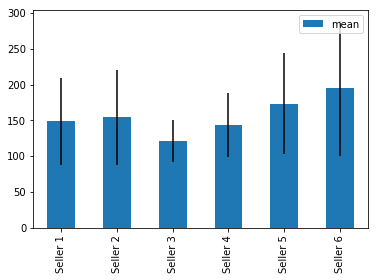

In [9]:
cis.plot(kind="bar", yerr="ci") # y error == "confidence interval"

# Let's check if our data is normally distributed

First we pivot the dataframe using the `melt` command to put all of the values into one 'Sales' column. 

In [10]:
df_pivot = pd.melt(df,value_vars=['Seller 1','Seller 2','Seller 3','Seller 4','Seller 5','Seller 6'], 
                   var_name="Sellers", value_name="Sales")
df_pivot.sample(5)

,Sellers,Sales
138,Seller 5,62
93,Seller 4,44
125,Seller 5,730
48,Seller 2,215
119,Seller 4,113


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1163ec940>]],
      dtype=object)

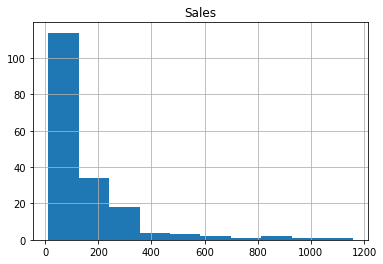

In [11]:
df_pivot.hist()

Then we can use a [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) (a quantile-quantile plot) to see if we have a normal distribution.

To do that we plot the sales values against a randomly generated normally-distributed set of new values.

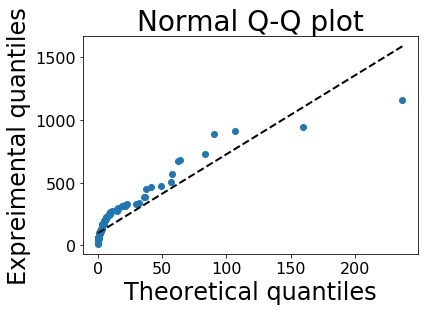

In [12]:
# http://scientificpythonsnippets.com/index.php/distributions/6-q-q-plot-in-python-to-test-if-data-is-normally-distributed

# get all of the sales values and plot them against a normally-distributed set of quantiles
sales = df_pivot["Sales"].copy()
sales.sort_values(inplace=True)
norm=random.lognormal(0,2,len(sales))
norm.sort()
plt.plot(norm,sales,"o")

# add a trend line and make it pretty
z = np.polyfit(norm,sales, 1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k--", linewidth=2)
plt.title("Normal Q-Q plot", size=28)
plt.xlabel("Theoretical quantiles", size=24)
plt.ylabel("Expreimental quantiles", size=24)
plt.tick_params(labelsize=16)

# plot all all values from data set under examination (the curvy line)
# against values taken from a known distribution (normal in this case)


For comparison, we can also plot two normally distributed sets against one another.

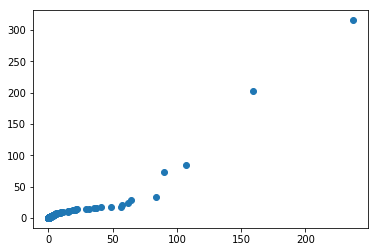

In [13]:
norm2=random.lognormal(0,2,len(sales))
norm2.sort()
plt.plot(norm,norm2,"o")

If the data isn't normally distributed. Bootstrap CIs might be a better choice.

(A histogram could also have shown us this.)

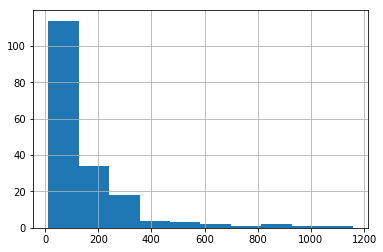

In [20]:
np.sort(sales)
sales.hist()

This data probably has a log-normal distribution. Which we can test by taking the log.

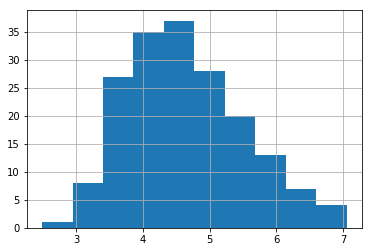

In [14]:
np.log(sales).hist()

...we can always reverse that by taking the exponent.

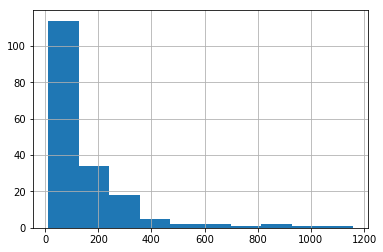

In [15]:
np.exp(np.log(sales)).hist()

If we wanted to, we could log-transform the data, compute CIs, then convert back before plotting.
This would give more accurate confidence intervals (you can try later if you'd like).
Instead, for now, we'll compute bootstrap confidence intervals.

# Bootstrap confidence intervals in Seaborn

The [Seaborn charting package](https://seaborn.github.io) supports bootstrap confidence intervals by default on most of it's chart types. 

If you don't already have seaborn installed, open a terminal or command prompt and run:
`conda install seaborn`

In [16]:
# Import seaborn
import seaborn as sns

**Draw a bar plot to show each seller.**

Use the `ci` parameter to set the confidence interval and the `n_boot` parameter to set the number of samples.

**Try experimenting with different sized confidence intervals and different numbers of bootstrap samples.**

*How does this change the size of the confidence intervals?*
*What happens if you re-run multiple times?*

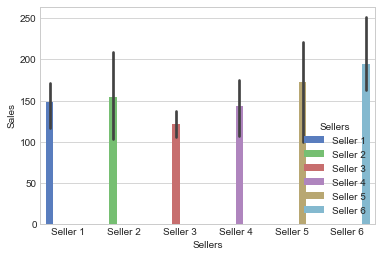

In [17]:
sns.set_style('whitegrid')
g = sns.barplot(x="Sellers", y="Sales", hue="Sellers", data=df_pivot,
                palette="muted", ci=95, n_boot=10)

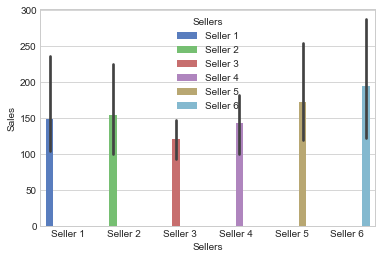

In [18]:
sns.set_style('whitegrid')
g = sns.barplot(x="Sellers", y="Sales", hue="Sellers", data=df_pivot,
                palette="muted", ci=95, n_boot=100)

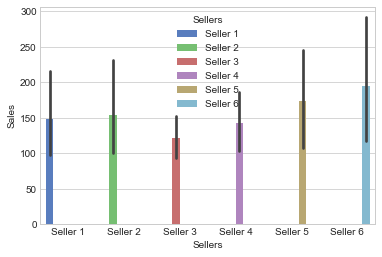

In [19]:
g = sns.barplot(x="Sellers", y="Sales", hue="Sellers", data=df_pivot,
                palette="muted", ci=95, n_boot=1000)

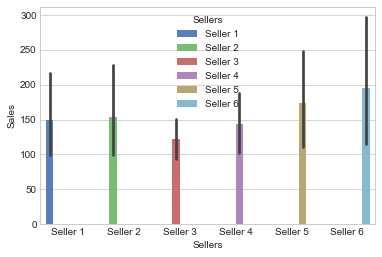

In [20]:
g = sns.barplot(x="Sellers", y="Sales", hue="Sellers", data=df_pivot,
                palette="muted", ci=95, n_boot=10000)

# Confidence intervals for pairwise comparisons
If we want to see if one seller reliably sells more than another seller on a daily basis, we can test that directly.

In [21]:
df_comp = DataFrame({"Seller 6 - 3":(df['Seller 6'] - df['Seller 3']),
                     "Seller 6 - 5":(df['Seller 6'] - df['Seller 5'])})
df_comp.head(5)

,Seller 6 - 3,Seller 6 - 5
day,,
1,248,254
2,-69,-153
3,49,40
4,797,819
5,180,178


In [22]:
df_comp_pivot = pd.melt(df_comp,value_vars=['Seller 6 - 3','Seller 6 - 5'], 
                   var_name="Seller Pair", value_name="Difference in Sales")
df_comp_pivot.sample(5)

,Seller Pair,Difference in Sales
12,Seller 6 - 3,1102
56,Seller 6 - 5,-24
48,Seller 6 - 5,10
47,Seller 6 - 5,169
22,Seller 6 - 3,-127


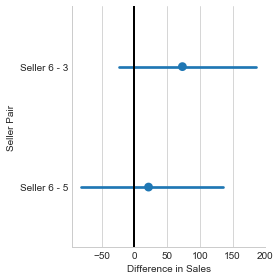

In [23]:
sns.factorplot(y="Seller Pair", x="Difference in Sales", data=df_comp_pivot,
               join=False,ci=95, n_boot=1000)
plt.axvline(0,lw=2,color="k")

# Now...
Have a look at the `sales-full.csv` dataset.
Are there any clear differences in it?

In [24]:
df = pd.read_csv('sales-full.csv')
df.sample(10)

,day,Seller 1,Seller 2,Seller 3,Seller 4,Seller 5,Seller 6
125,126,428,70,168,358,64,211
140,141,197,872,169,46,197,81
261,262,166,215,65,227,63,67
279,280,21,49,85,433,93,256
104,105,35,443,22,25,160,46
241,242,39,72,134,331,278,21
270,271,133,83,16,160,237,169
81,82,317,39,333,43,127,35
275,276,177,31,79,216,272,30
235,236,157,91,54,548,31,325


**Question #1**
Based on the full data, are any of the encyclopedia sellers in this set clearly different from the others in terms of average daily sales? Who would you give a raise?

In [25]:
df_comp_6 = DataFrame({"Seller 6 - 1":(df['Seller 6'] - df['Seller 1']),
                       "Seller 6 - 2":(df['Seller 6'] - df['Seller 2']),
                       "Seller 6 - 3":(df['Seller 6'] - df['Seller 3']),
                       "Seller 6 - 4":(df['Seller 6'] - df['Seller 4']),
                       "Seller 6 - 5":(df['Seller 6'] - df['Seller 5'])})

df_comp_5 = DataFrame({"Seller 5 - 1":(df['Seller 5'] - df['Seller 1']),
                       "Seller 5 - 2":(df['Seller 5'] - df['Seller 2']),
                       "Seller 5 - 3":(df['Seller 5'] - df['Seller 3']),
                       "Seller 5 - 4":(df['Seller 5'] - df['Seller 4']),
                       "Seller 5 - 6":(df['Seller 5'] - df['Seller 6'])})

df_comp_4 = DataFrame({"Seller 4 - 1":(df['Seller 4'] - df['Seller 1']),
                       "Seller 4 - 2":(df['Seller 4'] - df['Seller 2']),
                       "Seller 4 - 3":(df['Seller 4'] - df['Seller 3']),
                       "Seller 4 - 5":(df['Seller 4'] - df['Seller 5']),
                       "Seller 4 - 6":(df['Seller 4'] - df['Seller 6'])})

df_comp_3 = DataFrame({"Seller 3 - 1":(df['Seller 3'] - df['Seller 1']),
                       "Seller 3 - 2":(df['Seller 3'] - df['Seller 2']),
                       "Seller 3 - 4":(df['Seller 3'] - df['Seller 4']),
                       "Seller 3 - 5":(df['Seller 3'] - df['Seller 5']),  
                       "Seller 3 - 6":(df['Seller 3'] - df['Seller 6'])})

df_comp_2 = DataFrame({"Seller 2 - 1":(df['Seller 2'] - df['Seller 1']),
                       "Seller 2 - 3":(df['Seller 2'] - df['Seller 3']),
                       "Seller 2 - 4":(df['Seller 2'] - df['Seller 4']),
                       "Seller 2 - 5":(df['Seller 2'] - df['Seller 5']),
                       "Seller 2 - 6":(df['Seller 2'] - df['Seller 6'])})

df_comp_1 = DataFrame({"Seller 1 - 2":(df['Seller 1'] - df['Seller 2']),
                       "Seller 1 - 3":(df['Seller 1'] - df['Seller 3']),
                       "Seller 1 - 4":(df['Seller 1'] - df['Seller 4']),
                       "Seller 1 - 5":(df['Seller 1'] - df['Seller 5']),
                       "Seller 1 - 6":(df['Seller 1'] - df['Seller 6'])})

In [26]:
df_comp_pivot_6 = pd.melt(df_comp_6,value_vars=[
                   'Seller 6 - 1',
                   'Seller 6 - 2',
                   'Seller 6 - 3',
                   'Seller 6 - 4',
                   'Seller 6 - 5'], 
                   var_name="Seller Pair", value_name="Difference in Sales")

df_comp_pivot_5 = pd.melt(df_comp_5,value_vars=[
                   'Seller 5 - 1',
                   'Seller 5 - 2',
                   'Seller 5 - 3',
                   'Seller 5 - 4',
                   'Seller 5 - 6'], 
                   var_name="Seller Pair", value_name="Difference in Sales")

df_comp_pivot_4 = pd.melt(df_comp_4,value_vars=[
                   'Seller 4 - 1',
                   'Seller 4 - 2',
                   'Seller 4 - 3',
                   'Seller 4 - 5',
                   'Seller 4 - 6'], 
                   var_name="Seller Pair", value_name="Difference in Sales")

df_comp_pivot_3 = pd.melt(df_comp_3,value_vars=[
                   'Seller 3 - 1',
                   'Seller 3 - 2',
                   'Seller 3 - 4',
                   'Seller 3 - 5',
                   'Seller 3 - 6'], 
                   var_name="Seller Pair", value_name="Difference in Sales")

df_comp_pivot_2 = pd.melt(df_comp_2,value_vars=[
                   'Seller 2 - 1',
                   'Seller 2 - 3',
                   'Seller 2 - 4',
                   'Seller 2 - 5',
                   'Seller 2 - 6'], 
                   var_name="Seller Pair", value_name="Difference in Sales")

df_comp_pivot_1 = pd.melt(df_comp_1,value_vars=[
                   'Seller 1 - 2',
                   'Seller 1 - 3',
                   'Seller 1 - 4',
                   'Seller 1 - 5',
                   'Seller 1 - 6'], 
                   var_name="Seller Pair", value_name="Difference in Sales")

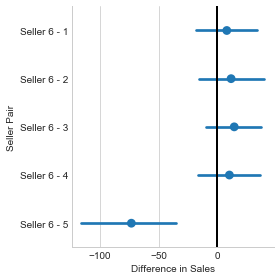

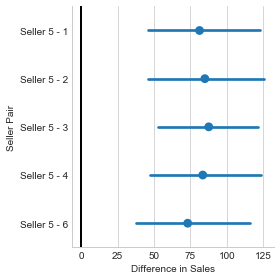

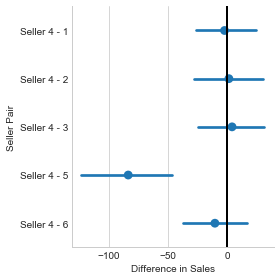

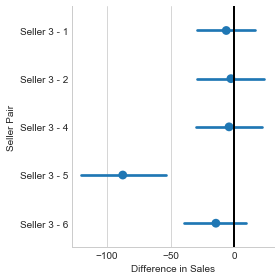

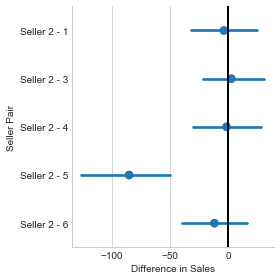

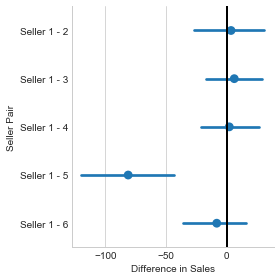

In [27]:
sns.factorplot(y="Seller Pair", x="Difference in Sales", data=df_comp_pivot_6,
               join=False,ci=95, n_boot=1000)
plt.axvline(0,lw=2,color="k")

sns.factorplot(y="Seller Pair", x="Difference in Sales", data=df_comp_pivot_5,
               join=False,ci=95, n_boot=1000)
plt.axvline(0,lw=2,color="k")

sns.factorplot(y="Seller Pair", x="Difference in Sales", data=df_comp_pivot_4,
               join=False,ci=95, n_boot=1000)
plt.axvline(0,lw=2,color="k")

sns.factorplot(y="Seller Pair", x="Difference in Sales", data=df_comp_pivot_3,
               join=False,ci=95, n_boot=1000)
plt.axvline(0,lw=2,color="k")

sns.factorplot(y="Seller Pair", x="Difference in Sales", data=df_comp_pivot_2,
               join=False,ci=95, n_boot=1000)
plt.axvline(0,lw=2,color="k")

sns.factorplot(y="Seller Pair", x="Difference in Sales", data=df_comp_pivot_1,
               join=False,ci=95, n_boot=1000)
plt.axvline(0,lw=2,color="k")

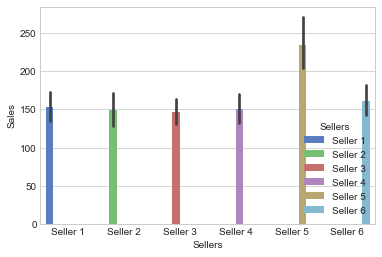

In [28]:
df_pivot = pd.melt(df,value_vars=['Seller 1','Seller 2','Seller 3','Seller 4','Seller 5','Seller 6'], 
                   var_name="Sellers", value_name="Sales")

sns.set_style('whitegrid')
g = sns.barplot(x="Sellers", y="Sales", hue="Sellers", data=df_pivot,
                palette="muted", ci=95, n_boot=1000)

## Seller 5 is clearly the best salesperson in the full dataset.

**Question #2**
We have data from six sellers from a company with many more. Based on this sample, does it look like the weeks with the best *average daily sales per seller* are clearly different from the weeks with the worst *average daily sales per seller*? 
*(Be sure to think about your unit of analysis.)*

In [29]:
df = pd.read_csv('sales-full.csv')

In [30]:
# Declare dataframe for pivoted data:
df_weeks = pd.DataFrame(columns=['Sellers', 'Sales', 'Week', 'Week Avg'])

# Split data into 5-day weeks:
for i in range(len(df)//5):
    
    # Determine averages for ordering later on:
    s1_avg = df[0:5]['Seller 1'].mean()
    s2_avg = df[0:5]['Seller 2'].mean()
    s3_avg = df[0:5]['Seller 3'].mean()
    s4_avg = df[0:5]['Seller 4'].mean()
    s5_avg = df[0:5]['Seller 5'].mean()
    s6_avg = df[0:5]['Seller 6'].mean()
    week_avg = (s1_avg + s2_avg + s3_avg + s4_avg + s5_avg + s6_avg) / 6
    
    # Pivot weekly data:
    df_week_pivot = pd.melt(df[0:5],value_vars=['Seller 1','Seller 2','Seller 3','Seller 4','Seller 5','Seller 6'], 
                   var_name='Sellers', value_name='Sales')
    
    # Add columns:
    df_week_pivot['Week'] = i + 1
    df_week_pivot['Week Avg'] = week_avg
    
    # Append current weeks' data into master dataframe:
    df_weeks = df_weeks.append(df_week_pivot, ignore_index=True)
    
    # Remove week that was just processed:
    df = df[5:]

In [31]:
# Sort data by overall weekly averages:
df_weeks = df_weeks.sort_values(by='Week Avg')

# Create an ordering list for the barplot:
wk_order = []
for week in df_weeks['Week']:
    if week not in wk_order:
        wk_order.append(week)

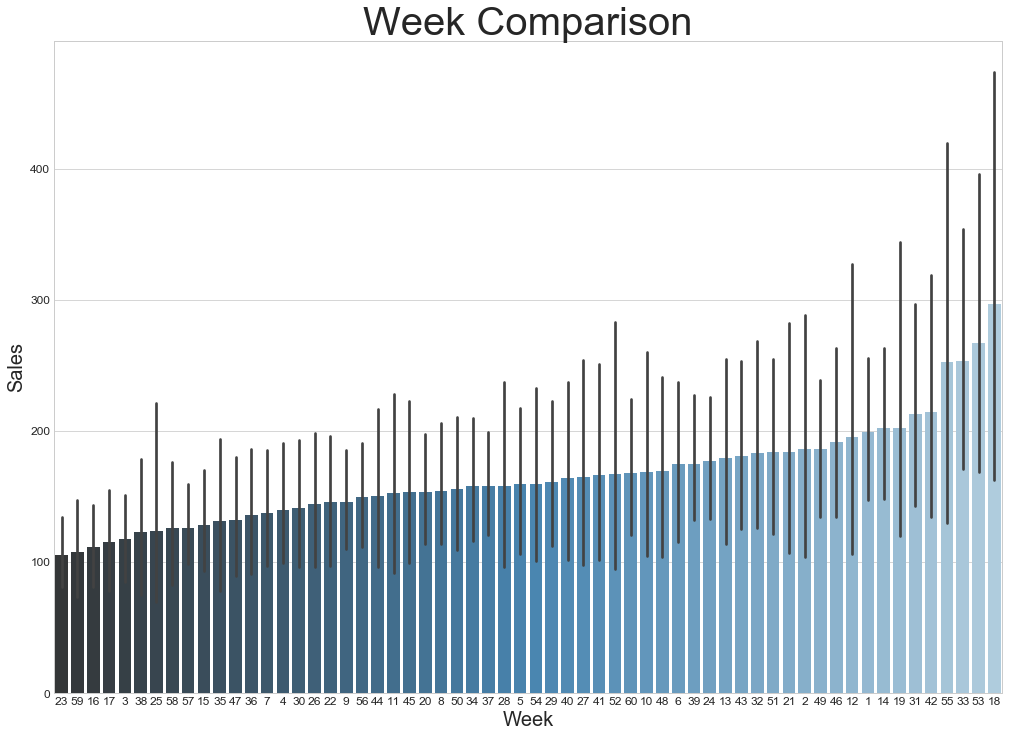

In [38]:
# Define barplot dimensions and Seaborn settings:
a4_dims = (17, 12)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.set_style('whitegrid')

# Plot the data, bootstrapping each week to generate confidence intervals:
wks_plot = sns.barplot(ax=ax, x='Week', y='Sales', data=df_weeks, order=wk_order,
                       palette="Blues_d", ci=95, n_boot=1000)

# Define labels and sizing:
wks_plot.axes.set_title("Week Comparison",fontsize=40)
wks_plot.set_xlabel("Week",fontsize=20)
wks_plot.set_ylabel("Sales",fontsize=20)
wks_plot.tick_params(labelsize=12)

**Question #3** {Question of your choice.}

In [110]:
df = pd.read_csv('sales-full.csv')

In [108]:
# Declare dataframe for day info:
df_days = pd.DataFrame(columns=['Day', 'Day Avg'])

day_names = {1.0 : 'Monday',
             2.0 : 'Tuesday',
             3.0 : 'Wednesday',
             4.0 : 'Thursday',
             5.0 : 'Friday',
}

# Split data by day and calculate each day's mean sales:
for i in range(len(df)):
    
    # Determine the mean sales for day i:
    day_avg = df.iloc[i][['Seller 1','Seller 2','Seller 3','Seller 4','Seller 5','Seller 6']].mean()
    
    # Determine day of the week:
    day = (df.iloc[i]['day'] % 5) + 1
    
    # Append current days' data into master dataframe:
    df_days.loc[i] = [day_names[day], day_avg]

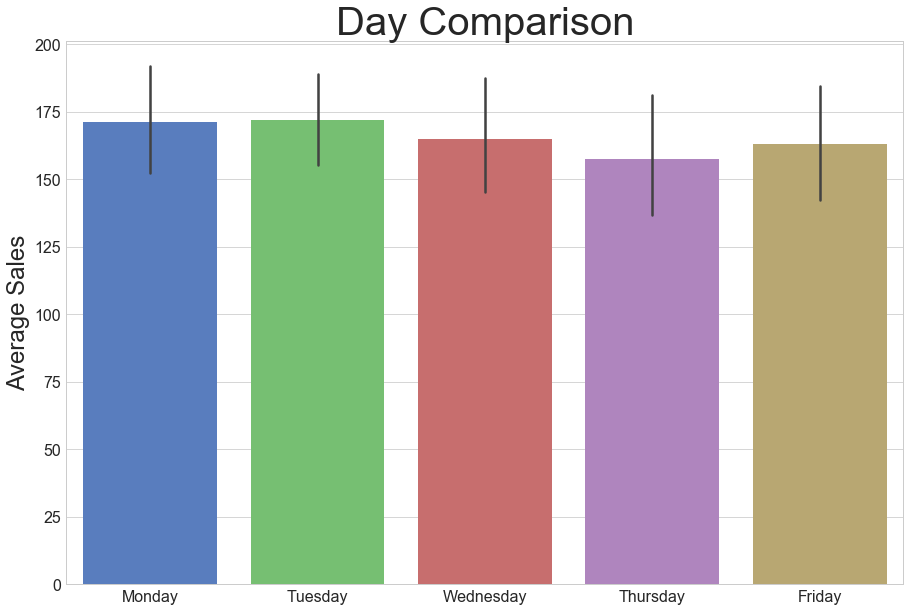

In [128]:
# Define barplot dimensions and Seaborn settings:
a4_dims = (15, 10)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.set_style('whitegrid')

ordering = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Plot the data, bootstrapping each week to generate confidence intervals:
days_plot = sns.barplot(ax=ax, x='Day', y='Day Avg', data=df_days, 
                        order=ordering, palette="muted", ci=95, n_boot=1000)

# Define labels and sizing:
days_plot.axes.set_title("Day Comparison",fontsize=40)
days_plot.set_ylabel("Average Sales",fontsize=24)
days_plot.set_xlabel("",fontsize=0)
days_plot.tick_params(labelsize=16)